# Production Model and Conclusion

In the time we had to test a variety of models, we found that our logistic regression model using CountVectorizer performed the best in terms of accuracy as well as being one of the quicker models to implement. Another advantage of using our logistic regression model is that it is easy to understand.

In [19]:
# import our libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [20]:
# import dataset

translated_df = pd.read_csv('../data/translated.csv')
translated_df.head()

,subreddit,merged_text
0,1,Fix to not being able to attack? Has anybody f...
1,1,Attack glitch during Regi raids 2 raids today ...
2,1,[Bug?] Can’t seem to earn or collect pokecoins...
3,1,"[Bug?] AR suddenly freezes Using an iPhone 11,..."
4,1,3 hour incense event personal results For any ...


In [21]:
# remove duplicate entries where text is the same
translated_df = translated_df.drop_duplicates('merged_text')

In [22]:
# create train_test_split to evaluate our baseline model
X = translated_df['merged_text']
y = translated_df['subreddit']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [24]:
# create a custom stop words list to remove all similar words we found in the previous notebook

# start with the base english stopwords
new_stopwords = stopwords.words('english')

# add stopwords that will easily identify a silph post
# also added stopwords that are common across both subreddits and stop words as a result and lemmatizing and stemming
custom_words = ['silph', 'road', 'silphroad', 'thesilphroad', 'pokemon', 'go', 'get', 'one', 'like', 'would', 'know', 'time', 'game', 'shiny', 
               'https', 'raid', 'anyone', 'got', 'new', 'event', 'day', 'level', 'even', 'com', 'raids', 'still', 'people', 'also', 'since',
               'use', 'catch', 'amp', 'see', 'want', 'could', 'first', 'research', 'shadow', 'think', 'else', 'way', 'niantic', 'make', 
               'back', 'really', 'need', 'eggs', 'community', 'something', 'much', 'good', 'able', "'d", "'ll", "'re", "'s", "'ve", 'abl', 
                'abov', 'ani', 'anyon', 'becaus', 'befor', 'commun', 'doe', 'dure', 'egg', 'els', 'ha', 'hi', 'http', 'might', 'must', 
                "n't", 'onc', 'onli', 'ourselv', 'peopl', 'realli', 'sha', 'shini', 'sinc', 'someth', 'themselv', 'thi', 'veri', 'wa', 
                'whi', 'wo', 'yourselv', 'becau', 'el']

new_stopwords.extend(custom_words)

In [25]:
# custom preprocessing of text 
# thanks to the following article for the code: https://kavita-ganesan.com/how-to-use-countvectorizer/#CountVectorizer-Plain-and-Simple

lemmatizer = WordNetLemmatizer()
def lemma_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [26]:
# create logistic regression pipeline using best params from earlier gridsearch
cvec_logr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new_stopwords, strip_accents = 'unicode', preprocessor = lemma_preprocessor, 
                             ngram_range = (1,1), min_df = 3, max_features = 53400, max_df = 0.822222)),
    ('logr', LogisticRegression(penalty = 'l2', C = 0.04313873873873874))
])

In [27]:
cvec_sentiment_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.822222, max_features=53400, min_df=3,
                                 preprocessor=<function lemma_preprocessor at 0x7fc62b31b5e0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('logr', LogisticRegression(C=0.04313873873873874))])

In [30]:
# check accuracy of our models
cvec_sentiment_pipe.score(X_train, y_train)

0.7876249837683418

In [31]:
y_pred = cvec_sentiment_pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.7169566346403532

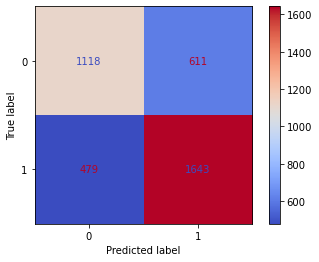

In [33]:
# create confusion matrix to evaluate sensitivy and specificity 
plot_confusion_matrix(cvec_sentiment_pipe, X_test, y_test, cmap = 'coolwarm')

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'Sensitivity: {(tp) / (tp + fn)}')
print(f'Specificity: {(tn) / (tn + fp)}')


Sensitivity: 0.7742695570216777
Specificity: 0.6466165413533834


Here we can see that we would want to improve the specificity of our model and not classify pokemongo posts as TheSilphRoad posts. The danger in classifying pokemongo posts as TheSilphRoad is that we are showing that TheSilphRoad isn't as superior as it markets itself to be. 

In [59]:
# find which features are the best at determining if a post is from TheSilphRoad
coefficients = cvec_sentiment_pipe.named_steps['logr'].coef_[0]

In [60]:
features = cvec_sentiment_pipe.named_steps['cvec'].get_feature_names()

In [61]:
len(features)

8617

In [62]:
coefficients

array([-0.03495012, -0.00625315,  0.00379659, ...,  0.02302707,
       -0.10912901,  0.04517083])

In [70]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df = coef_df.set_index('features')
coef_df.head()

,coef,exp_coef
features,,
00,-0.034950,0.965654
000,-0.006253,0.993766
000010,0.003797,1.003804
000km,-0.068278,0.934001
000xp,-0.173376,0.840821


In [71]:
coef_df['exp_coef'].sort_values(ascending = False).head(10).index

Index(['poll', 'title', 'gbl', 'info', 'bug', 'megas', 'master', 'giratina',
       'articuno', 'related'],
      dtype='object', name='features')

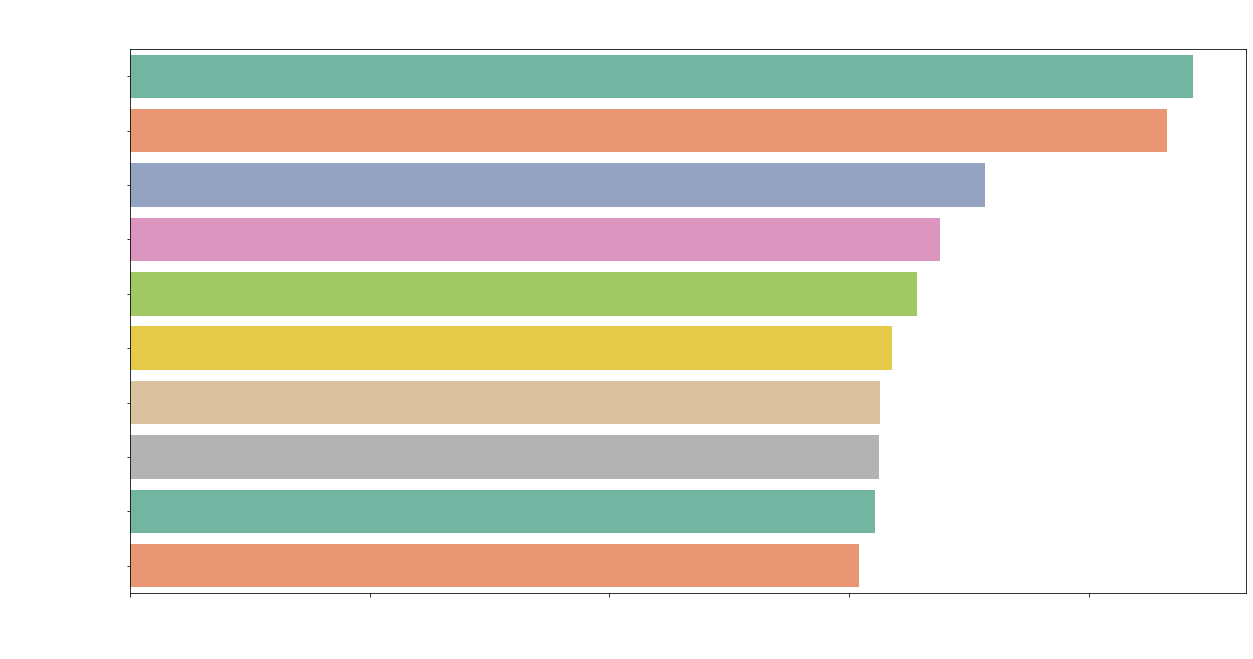

In [78]:
plt.figure(figsize=(20,10))
sns.barplot(y = coef_df['exp_coef'].sort_values(ascending = False).head(10).index, 
           x = coef_df['exp_coef'].sort_values(ascending = False).head(10), orient = 'h',
           palette = sns.color_palette("Set2"))
plt.yticks(fontsize=20, color = 'white')
plt.xticks(fontsize=20, color = 'white')
plt.xlabel('Exp Coef', fontsize=30, color = 'white')
plt.ylabel('Words', fontsize = 30, color = 'white')
plt.title(f'Top 10 Features - TheSilphRoad', fontsize=42, color = 'white', fontweight = 'bold')
plt.savefig('../images/top_10_features.png')

Some of the keywords here that could be classified as being language of a more experience player are gbl, bug, megas, master, giratina, and articuno. These words are all part of aspects of the game that only someone that has put a lot of time and effort into Pokémon Go would use on a regular basis. 

## Conclusion

While we weren't able to build a model that definitively classified a post as being from TheSilphRoad or pokemongo subreddit, reaching around 72% accuracy is quite good for two subreddits that are about the same game. With more time, I would want to try building a sentiment analyzer that weighs certain words that a seasoned Pokémon Go would use more heavily, as well as conducting grid searches on more complex models. A final thing we could try to improve our models is build a custom vectorizer that weighs certain words more heavily. 